## 15.2 用GPT-2生成新闻
	想要直接运行一个预训练好的 GPT-2 模型，最简单的方法是让它自由工作，即随机生成文本。换句话说，在开始时，我们给它一点提示，即一个预定好的起始单词，然后让它自行地随机生成后续的文本。
	但这样有时可能会出现问题，例如模型陷入一个循环，不断生成同一个单词。为了避免这种情况， GPT-2 设置了一个 top-k 参数，这样模型就会从概率前 k 大的单词中随机选取一个单词，作为下一个单词。下面是选择 top-k 的函数的实现。

### 15.2.1 定义随机选择函数
1）定义随机选择函数

In [1]:
import random

def select_top_k(predictions, k=10):
    predicted_index = random.choice(
        predictions[0, -1, :].sort(descending=True)[1][:10]).item()
    return predicted_index

2）导入分词库等

In [2]:
import warnings
warnings.filterwarnings('ignore')

import torch
from transformers import GPT2Tokenizer

import logging
logging.basicConfig(level=logging.INFO)

# 载入预训练模型的分词器
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json from cache at /home/wumg/.cache/torch/transformers/f2808208f9bec2320371a9f5f891c184ae0b674ef866b79c58177067d15732dd.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71
INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt from cache at /home/wumg/.cache/torch/transformers/d629f792e430b3c76a1291bb2766b0a047e36fae0588f9dbc1ae51decdff691b.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda


3）测试GPT2Tokenizer

In [3]:
# 使用 GPT2Tokenizer 对输入进行编码
text = "Yesterday, a man named Jack said he saw an alien,"
indexed_tokens = tokenizer.encode(text)
tokens_tensor = torch.tensor([indexed_tokens])
tokens_tensor.shape

torch.Size([1, 12])

### 15.2.2预训练模型生成新闻
	接下来使用 GPT2LMHeadModel() 建立模型，并将模型模式设为验证模式。由于预训练模型参数体积很大，这里把相关模块先下载，然后放在本地的gpt目录下。下载GPT-2预训练模型。具体下载方法如下。
进入huggingface官网（https://huggingface.co/models），选择预训练模型，如下图所示。
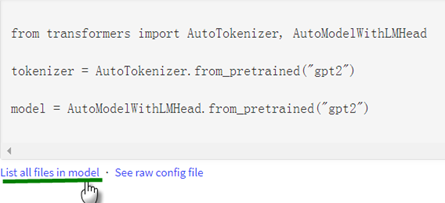

点击list all files in model，进入下载文件界面，如下图所示
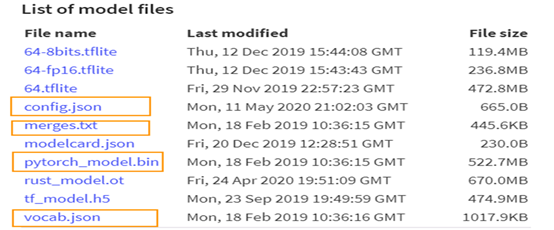
这里使用PyTorch，所以选择pytorch_model.bin。如果使用TensorFlow平台，则选择tf_model.h5，其他选项相同。
下面，用给定的text生成新闻。

In [4]:
from transformers import GPT2LMHeadModel

# 读取 GPT-2 预训练模型
model = GPT2LMHeadModel.from_pretrained("./gpt2")
model.eval()

total_predicted_text = text
n = 100  # 预测过程的循环次数
for _ in range(n):
    with torch.no_grad():
        outputs = model(tokens_tensor)
        predictions = outputs[0]

    predicted_index = select_top_k(predictions, k=10)
    predicted_text = tokenizer.decode(indexed_tokens + [predicted_index])
    total_predicted_text += tokenizer.decode(predicted_index)

    if '<|endoftext|>' in total_predicted_text:
        # 如果出现文本结束标志，就结束文本生成
        break

    indexed_tokens += [predicted_index]
    tokens_tensor = torch.tensor([indexed_tokens])

print(total_predicted_text)

INFO:transformers.configuration_utils:loading configuration file ./gpt2/config.json
INFO:transformers.configuration_utils:Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "vocab_size": 50257
}

INFO:transformers.modeling_utils:loading weights file ./gpt2/pytorch_model.bin
INFO:transformers.modeling_utils:All model checkpoint weights were used when initializing GPT2LMHeadModel.



Yesterday, a man named Jack said he saw an alien, who was flying in midstream in an airplane over North Korea's border and he called in an air support aircraft in his helicopter so as to take down the pilot and get out the other side of his ship to prevent any possible casualties and prevent anyone from going overboard." The UAS, according to Mr, has no record of a pilot flying within 500 km in that time range," the BBC report stated on the official site for Pyongyang. It did mention "an unidentified aircraft flying around in that air base


从结果来看，好像是一段正常的文本，不过，仔细看就会发现语句中的还存在一些不足之处。除了直接利用预训练模型生成文本，我们还可以使用微调的方法使 GPT-2 模型生成有特定风格和格式的文本。

## 15.3微调GPT-2生成戏剧文本
	接下来，我们将使用一些戏剧剧本对 GPT-2 进行微调，这里以莎士比亚的戏剧作品《罗密欧与朱丽叶》作为训练样本。
### 15.3.1 读取文件
	读取莎士比亚一个戏剧作品《罗密欧与朱丽叶》的文件数据。

In [5]:
with open('./data/romeo_and_juliet.txt', 'r') as f:
    dataset = f.read()

len(dataset)

138150

### 15.3.2 对文件进行分词
	对文件进行分词并把字符串分段成长度不超过 512个标识的长度。

In [6]:
indexed_text = tokenizer.encode(dataset)
del(dataset)

dataset_cut = []
for i in range(len(indexed_text)//512):
    # 将字符串分段成长度为 512
    dataset_cut.append(indexed_text[i*512:i*512+512])
del(indexed_text)

dataset_tensor = torch.tensor(dataset_cut)
dataset_tensor.shape

torch.Size([81, 512])

### 15.3.3 把数据集转换为可迭代对象
	利用dataloader方法，把数据集转换为可批量处理的迭代对象。

In [7]:
from torch.utils.data import DataLoader, TensorDataset

# 构建数据集和数据迭代器，设定 batch_size 大小为 2
train_set = TensorDataset(dataset_tensor,
                          dataset_tensor)  # 标签与样本数据相同
train_loader = DataLoader(dataset=train_set,
                          batch_size=1,
                          shuffle=False)
train_loader

### 15.3.4 训练模型
	训练模型，迭代30次，采用Adam优化方法，学习率为le-5。

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
from torch import nn
#from torch.autograd import Variable
import time

pre = time.time()

epoch = 30  # 循环学习 30 次

#model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # 定义优化器

for i in range(epoch):
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        #data, target = Variable(data).to(device), Variable(target).to(device)
        #data, target = data.to(device), target.to(device)
        data, target = data, target
        optimizer.zero_grad()

        loss, logits, _ = model(data, labels=target)
        
        #print(loss.shape)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        if batch_idx == len(train_loader)-1:
            # 在每个 Epoch 的最后输出一下结果
            print('average loss:', total_loss/len(train_loader))

print('训练时间：', time.time()-pre)

average loss: 3.996990050798581
average loss: 3.771802799201306
average loss: 3.6442165639665394
average loss: 3.540228358021489
average loss: 3.457483700764032
average loss: 3.3828501142101524
average loss: 3.334426626747037
average loss: 3.2673205446313927
average loss: 3.2216262140391785
average loss: 3.1702801092171375
average loss: 3.11912934868424
average loss: 3.0744085164717685
average loss: 3.0290320920355525
average loss: 2.985965446189598
average loss: 2.9440353799749306
average loss: 2.9014674204367177
average loss: 2.856362563592416
average loss: 2.8154661625991633
average loss: 2.768943610014739
average loss: 2.7287528779771595
average loss: 2.678513694692541
average loss: 2.645108296547407
average loss: 2.6046420085577315
average loss: 2.5613166682514144
average loss: 2.518730971548292
average loss: 2.482331374545156
average loss: 2.438081480838634
average loss: 2.392695540263329
average loss: 2.3639418784482977
average loss: 2.310071717073888
训练时间： 5421.882831811905


### 15.3.5 用模型生成文本
	利用训练好的GPT-2模型，根据提供的引导语句，推断一段新文字。

In [10]:
evice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
text = "From fairest creatures we desire"  # 这里也可以输入不同的英文文本
indexed_tokens = tokenizer.encode(text)
tokens_tensor = torch.tensor([indexed_tokens])

model.eval()
total_predicted_text = text

# 使训练后的模型进行 500 次预测
for _ in range(500):
    tokens_tensor = tokens_tensor

    with torch.no_grad():
        outputs = model(tokens_tensor)
        predictions = outputs[0]

    predicted_index = select_top_k(predictions, k=10)

    predicted_text = tokenizer.decode(indexed_tokens + [predicted_index])
    total_predicted_text += tokenizer.decode(predicted_index)
    if '<|endoftext|>' in total_predicted_text:
        # 如果出现文本结束标志，就结束文本生成
        break

    indexed_tokens += [predicted_index]

    if len(indexed_tokens) > 1023:
        # 模型最长输入长度为1024，如果长度过长则截断
        indexed_tokens = indexed_tokens[-1023:]

    tokens_tensor = torch.tensor([indexed_tokens])

print(total_predicted_text)

From fairest creatures we desire to be friends
Our lives may not stand but to be separated; we may call
This holy division death: this holy marriage must cease in our death. Thus saying farewell we besan our dead, that we should be as friends in death. Thus says he;
Death may not withdraw his holy order: 'tis but our common grief
In that part where thou wossiest death, and where death withdraw'd the blessings that we should
Dainst us by parting ways:'
So sayeth he our hearts will live on this vow for eon life. This last part of our vow may be quiesolved and our
marmarry be as dear a vow ours are; we do wish our death, but God give it not; let death remove this part which, in
that case may cease to denote our joy and joy our dead
should enjoy as part of life: this last of these we vow and that we bear as one.
NARRator Now is my brother, that he may now bring the case
Within his reach,
That the law forbearance with aloof accents may hereafter
Make this rite so inconstant
As if some other

从生成结果可以看到，模型已经学习到了戏剧剧本的文本特点。不过仔细读起来会发现缺少逻辑和关联，这是因为由于循环次数、语料等还不够充分。如果有更多的数据，训练更长的时间，这样模型应该有更好的表现。